<a href="https://colab.research.google.com/github/melikeavan/House-classification/blob/main/YapayZeka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from yellowbrick.cluster import KElbowVisualizer
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler,MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import files
uploaded = files.upload()
data= pd.read_csv("rental.csv.csv", sep= ',',encoding='utf-8', engine='python')

Saving rental.csv.csv to rental.csv (3).csv


In [ ]:
# Split işlemi: Verileri virgüle göre ayır ve sütunlara böl
data = data['Room Count,Price,Area (m2),Building Age'].str.split(',', expand=True)

# Yeni sütun isimlerini belirle
data.columns = ['Room Count', 'Price', 'Area (m2)', 'Building Age']

# Sayısal değerlere dönüştürmek için:
for col in ['Price', 'Area (m2)', 'Building Age']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Sonucu görüntüle
print(data.head())

  Room Count  Price  Area (m2)  Building Age
0        2+1  14500         90            18
1        2+1  20000         90             8
2        2+1  17000         85             0
3        2+1  19000         95             8
4        2+1  13000        110            13


In [ ]:
data.head()

,Room Count,Price,Area (m2),Building Age
0,2+1,14500,90,18
1,2+1,20000,90,8
2,2+1,17000,85,0
3,2+1,19000,95,8
4,2+1,13000,110,13


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Room Count    206 non-null    object
 1   Price         206 non-null    int64 
 2   Area (m2)     206 non-null    int64 
 3   Building Age  206 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.6+ KB


In [ ]:
data.tail()

,Room Count,Price,Area (m2),Building Age
201,2+1,13000,120,4
202,3+1,14000,125,4
203,1+1,10000,50,15
204,2+1,13000,100,3
205,4+1,23500,170,0


In [ ]:
data['Condition'] = data['Building Age'].apply(lambda x: 'Sıfır' if x <= 5 else 'İkinci El')

data.head()

,Room Count,Price,Area (m2),Building Age,Condition
0,2+1,14500,90,18,İkinci El
1,2+1,20000,90,8,İkinci El
2,2+1,17000,85,0,Sıfır
3,2+1,19000,95,8,İkinci El
4,2+1,13000,110,13,İkinci El


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Room Count    206 non-null    object
 1   Price         206 non-null    int64 
 2   Area (m2)     206 non-null    int64 
 3   Building Age  206 non-null    int64 
 4   Condition     206 non-null    object
dtypes: int64(3), object(2)
memory usage: 8.2+ KB


In [ ]:
data.isnull().sum()

,0
Room Count,0
Price,0
Area (m2),0
Building Age,0
Condition,0


In [ ]:
data.describe()

,Price,Area (m2),Building Age
count,206.000000,206.000000,206.000000
mean,20026.456311,116.859223,7.427184
std,14484.698960,61.188909,6.645889
min,7000.000000,50.000000,0.000000
25%,13625.000000,85.000000,3.000000
50%,16000.000000,95.000000,7.000000
75%,20000.000000,125.000000,9.750000
max,125000.000000,420.000000,38.000000


In [ ]:
duplicate_rows = data[data.duplicated()]
print("Tekrarlayan Satır Sayısı:", duplicate_rows.shape[0])

Tekrarlayan Satır Sayısı: 9


In [ ]:
# Tekrarlayan satırları veri setinden çıkarmak
data.drop_duplicates(inplace=True)

In [ ]:
duplicate_rows = data[data.duplicated()]
print("Tekrarlayan Satır Sayısı:", duplicate_rows.shape[0])

Tekrarlayan Satır Sayısı: 0


In [ ]:
# Oda ve salon sayılarını toplama işlemini yeni bir sütuna ekleme
data['Total Rooms'] = data['Room Count'].apply(lambda x: sum(map(int, x.split('+'))))
# Yeni sütunu ikinci sütun olarak ekleme
data.insert(1, 'Total Rooms', data.pop('Total Rooms'))
print(data)

    Room Count  Total Rooms  Price  Area (m2)  Building Age  Condition
0          2+1            3  14500         90            18  İkinci El
1          2+1            3  20000         90             8  İkinci El
2          2+1            3  17000         85             0      Sıfır
3          2+1            3  19000         95             8  İkinci El
4          2+1            3  13000        110            13  İkinci El
..         ...          ...    ...        ...           ...        ...
201        2+1            3  13000        120             4      Sıfır
202        3+1            4  14000        125             4      Sıfır
203        1+1            2  10000         50            15  İkinci El
204        2+1            3  13000        100             3      Sıfır
205        4+1            5  23500        170             0      Sıfır

[197 rows x 6 columns]


In [ ]:
le = LabelEncoder()
data['Condition'] = le.fit_transform(data['Condition'])
data.head()

,Room Count,Total Rooms,Price,Area (m2),Building Age,Condition
0,2+1,3,14500,90,18,1
1,2+1,3,20000,90,8,1
2,2+1,3,17000,85,0,0
3,2+1,3,19000,95,8,1
4,2+1,3,13000,110,13,1


In [ ]:

# İşlenmiş veriyi Excel formatında kaydet
data.to_excel('işlenmiş_veri.xlsx', index=False)

# Kaydedilen dosyanın durumunu kontrol etmek için:
print("İşlenmiş veri 'işlenmiş_veri.xlsx' olarak kaydedildi.")
from google.colab import files
files.download('işlenmiş_veri.xlsx')

İşlenmiş veri 'işlenmiş_veri.xlsx' olarak kaydedildi.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
x = data.iloc[:,1:4].values #bağımsız değişkenler
y = data.iloc[:,5:].values #bağımlı değişken
print(y)
print(x)

[[1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]]
[[     3  1450

In [ ]:
print(data.dtypes)

Room Count      object
Total Rooms      int64
Price            int64
Area (m2)        int64
Building Age     int64
Condition        int64
dtype: object


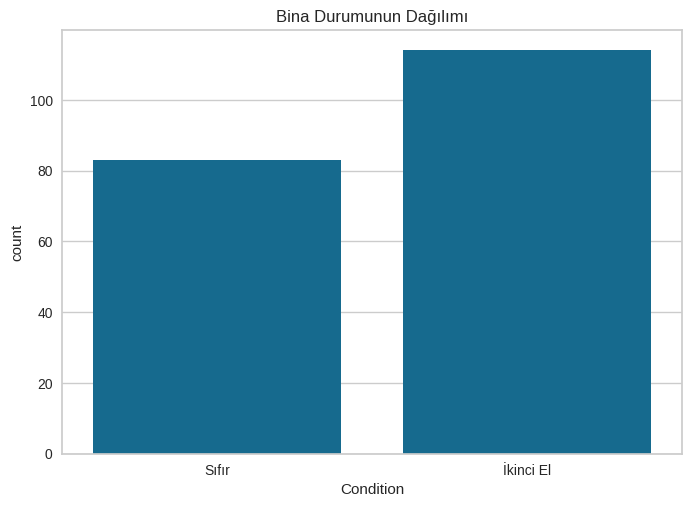

In [ ]:
# Condition sütunu için dağılım grafiği
sns.countplot(data=data, x="Condition")

# X eksenindeki etiketler
plt.xticks([0, 1], ['Sıfır', 'İkinci El'])

# Başlık ekleme
plt.title("Bina Durumunun Dağılımı")

# Grafiği gösterme
plt.show()

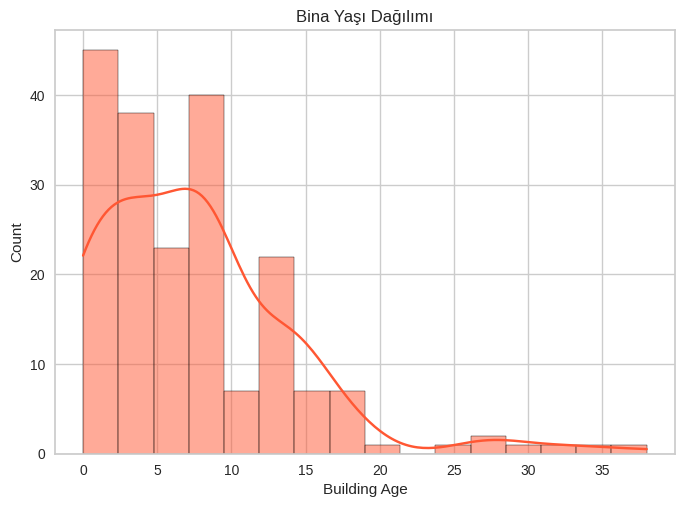

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Renk tanımlama
custom_colors = ["#FF5733", "#3366FF", "#33FF57"]  # Örnek renkler

# Histogram grafiği çizimi
sns.histplot(data['Building Age'], kde=True, color="#FF5733", palette=custom_colors)

# Başlık ekleme
plt.title("Bina Yaşı Dağılımı")

# Grafiği gösterme
plt.show()

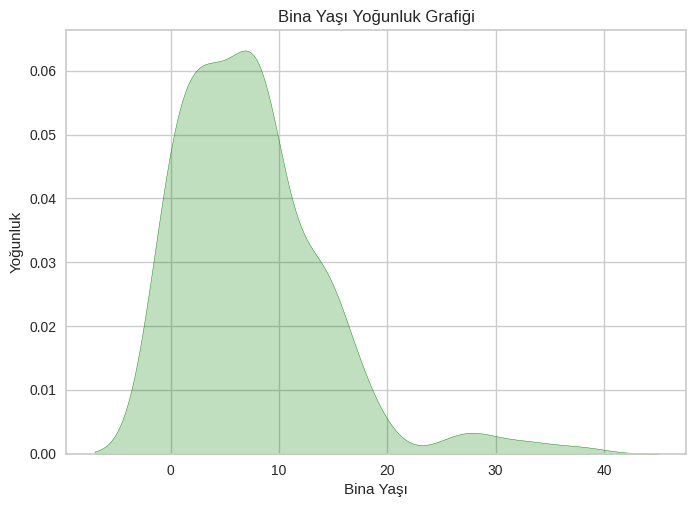

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Yoğunluk grafiği
sns.kdeplot(data['Building Age'], color="green", fill=True)

# Eksen ve başlık ayarları
plt.xlabel('Bina Yaşı')
plt.ylabel('Yoğunluk')
plt.title('Bina Yaşı Yoğunluk Grafiği')

# Grafiği gösterme
plt.show()

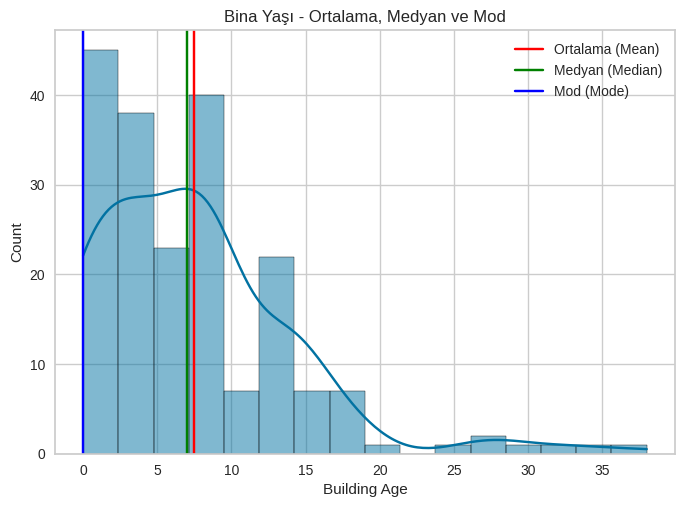

Ortalama (Mean): 7.50253807106599
Medyan (Median): 7.0
Mod (Mode): 0


In [ ]:
# Bina yaşları histogramı ve istatistik çizgileri
sns.histplot(data['Building Age'], kde=True)

# Ortalama (mean) çizgisi
plt.axvline(data['Building Age'].mean(), color='Red', label='Ortalama (Mean)')

# Medyan (median) çizgisi
plt.axvline(data['Building Age'].median(), color='Green', label='Medyan (Median)')

# Mod (mode) çizgisi
plt.axvline(data['Building Age'].mode()[0], color='Blue', label='Mod (Mode)')

# Başlık ve açıklama ekleme
plt.title("Bina Yaşı - Ortalama, Medyan ve Mod")
plt.legend()

# Grafiği gösterme
plt.show()

# Ortalama, medyan ve modu yazdırma
print('Ortalama (Mean):', data['Building Age'].mean())
print('Medyan (Median):', data['Building Age'].median())
print('Mod (Mode):', data['Building Age'].mode()[0])

In [ ]:
import plotly.express as px

# Histogram grafiği - Bina Yaşı ve Koşula göre renklendirme
fig = px.histogram(data_frame=data, x='Building Age', color='Condition',
                   color_discrete_map={1: "blue", 0: "orange"},
                   labels={"Condition": "Koşul (1: İkinci El, 0: Sıfır)"})

# Grafiği gösterme
fig.update_layout(title="Bina Yaşı Histogramı (Duruma Göre Renklendirilmiş)")
fig.show()

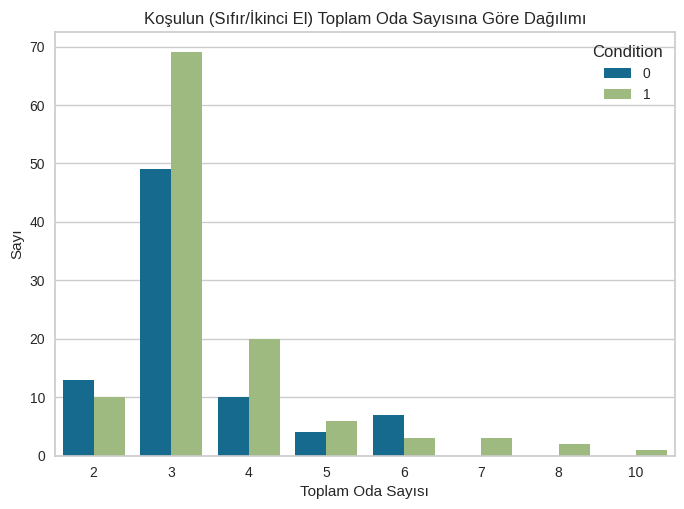

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot - Koşul ve Toplam Oda Sayısına Göre
sns.countplot(data=data, x='Total Rooms', hue='Condition')

# X ve Y eksenlerine etiket ekleme
plt.xlabel('Toplam Oda Sayısı')
plt.ylabel('Sayı')

# Başlık ekleme
plt.title("Koşulun (Sıfır/İkinci El) Toplam Oda Sayısına Göre Dağılımı")

# Grafiği gösterme
plt.show()

In [ ]:
import plotly.express as px

# Histogram grafiği - Bina Yaşı ve Toplam Oda Sayısına göre renklendirme
fig = px.histogram(data_frame=data, x='Building Age', color='Total Rooms',
                   labels={"Building Age": "Bina Yaşı", "Total Rooms": "Toplam Oda Sayısı"},
                   title="Bina Yaşı Histogramı (Toplam Oda Sayısına Göre Renklendirilmiş)")

# Grafiği gösterme
fig.show()

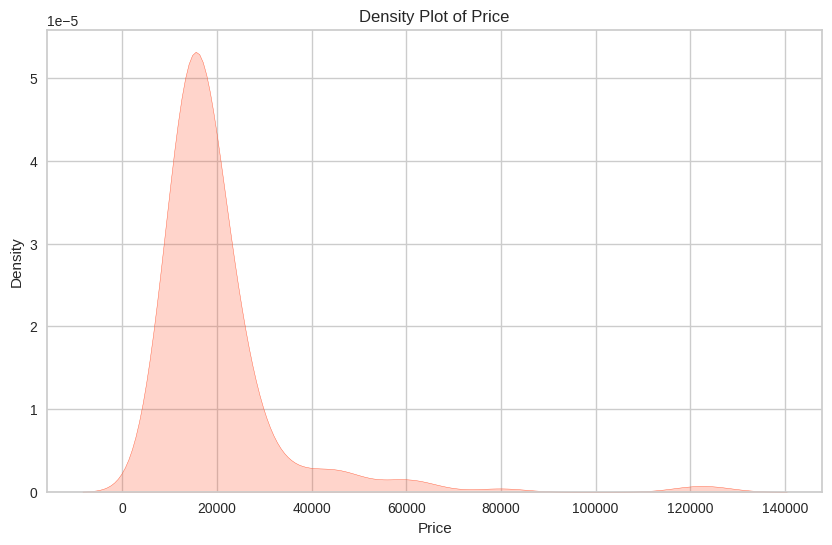

In [ ]:
# Yoğunluk grafiği oluşturma (örnek olarak 'Price' sütununu kulllanarak)
plt.figure(figsize=(10, 6))
sns.kdeplot(data['Price'], color="#FF5733", fill=True)
plt.title('Density Plot of Price')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

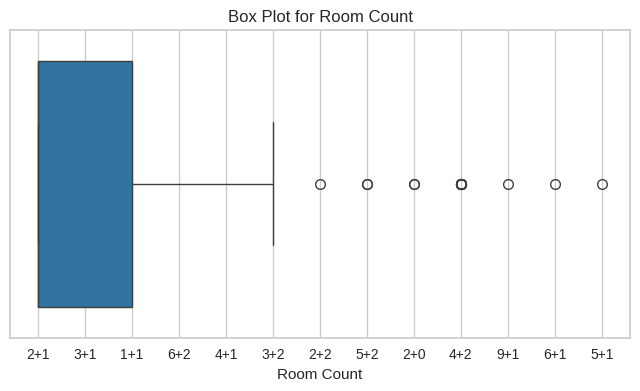

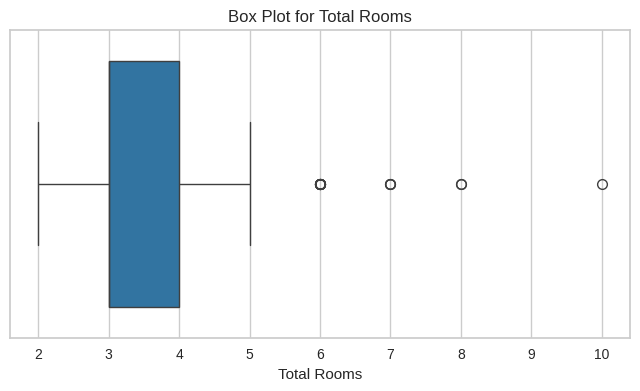

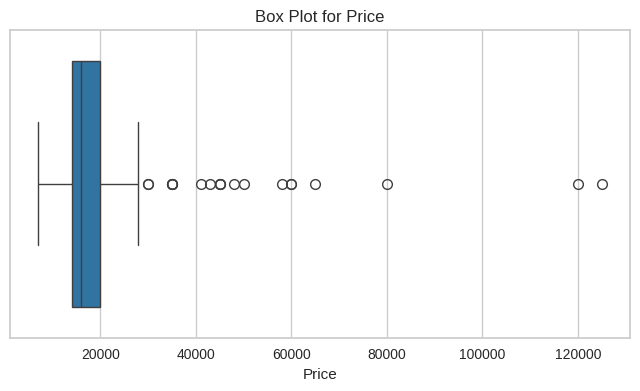

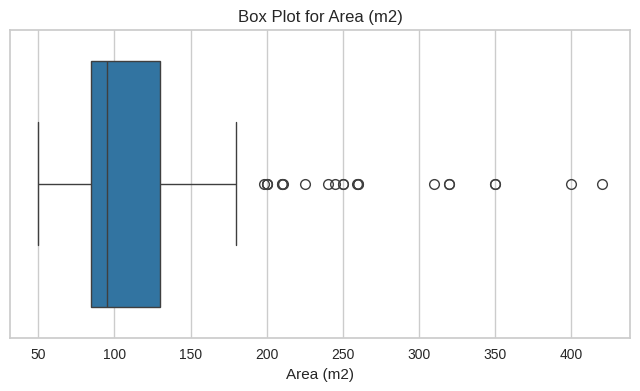

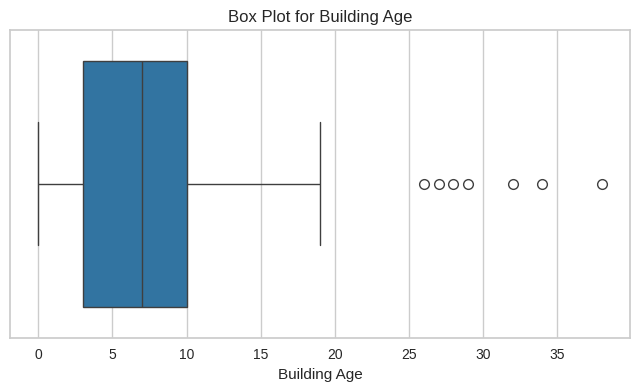

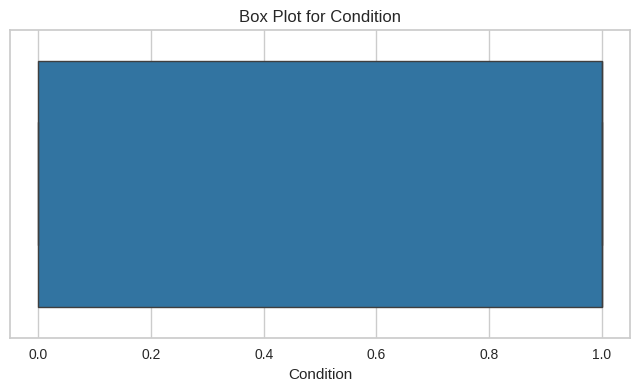

In [ ]:
# Tüm sütunlar için boxplot
for col in data.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col], color="#1f77b4")
    plt.title(f'Box Plot for {col}')
    plt.show()

Çıkarılan Aykırı Değer Sayısı: 16
Çıkarılan Aykırı Değerler:
    Room Count  Total Rooms   Price  Area (m2)  Building Age  Condition
10         6+2            8   41000        350            13          1
18         4+1            5   58000        260             7          1
21         5+2            7   48000        350             9          1
49         2+1            3   45000         80             7          1
73         4+2            6   45000        320             9          1
78         3+1            4    7000        115            32          1
85         5+2            7  125000        320            17          1
94         6+2            8  120000        420             7          1
108        9+1           10   65000        400            34          1
111        4+2            6   45000        250             4          0
138        6+1            7   80000        310             9          1
139        5+1            6   43000        245             3          0
149

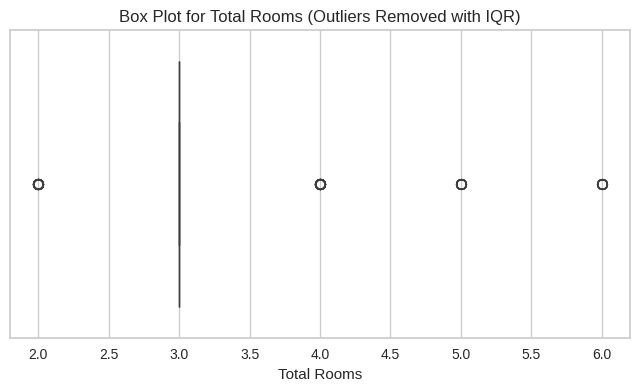

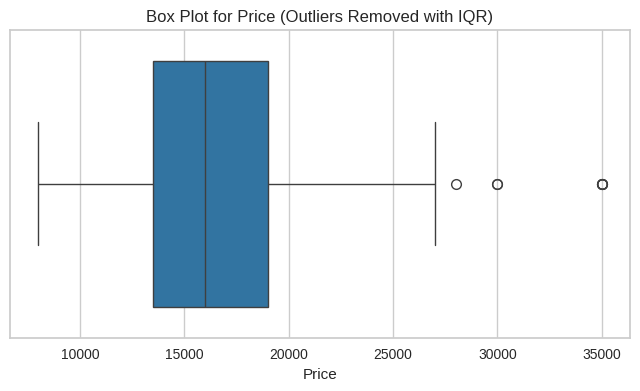

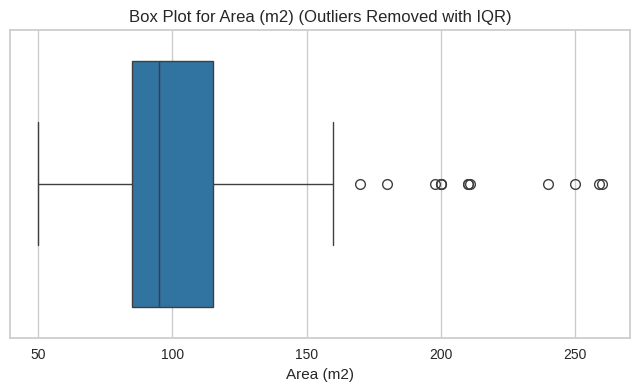

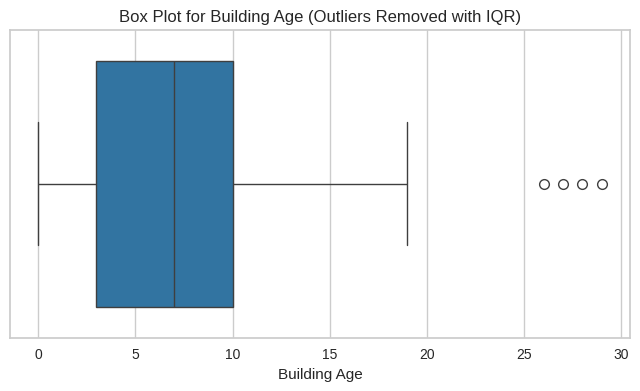

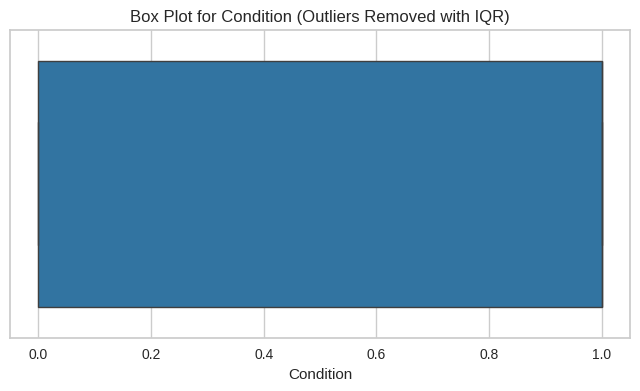

In [ ]:
# Sayısal sütunları seçme
numeric_cols = data.select_dtypes(include=[np.number]).columns

# Threshold (çarpan) değeri: Daha az aykırı değer için artırılabilir
threshold = 3.0

# IQR hesaplama
Q1 = data[numeric_cols].quantile(0.25)
Q3 = data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Alt ve üst sınırlar
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

# Aykırı değerleri tespit etme
outliers = data[((data[numeric_cols] < lower_bound) | (data[numeric_cols] > upper_bound)).any(axis=1)]

# Aykırı değerleri çıkarma
data = data[~((data[numeric_cols] < lower_bound) | (data[numeric_cols] > upper_bound)).any(axis=1)]

# Çıkarılan aykırı değer sayısı
print(f"Çıkarılan Aykırı Değer Sayısı: {outliers.shape[0]}")

# Çıkarılan aykırı değerleri görüntüleme
print("Çıkarılan Aykırı Değerler:")
print(outliers)

# Temizlenmiş veriyi görselleştirme (sayısal sütunlar için box plot çizimi)
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col], color="#1f77b4")
    plt.title(f'Box Plot for {col} (Outliers Removed with IQR)')
    plt.show()

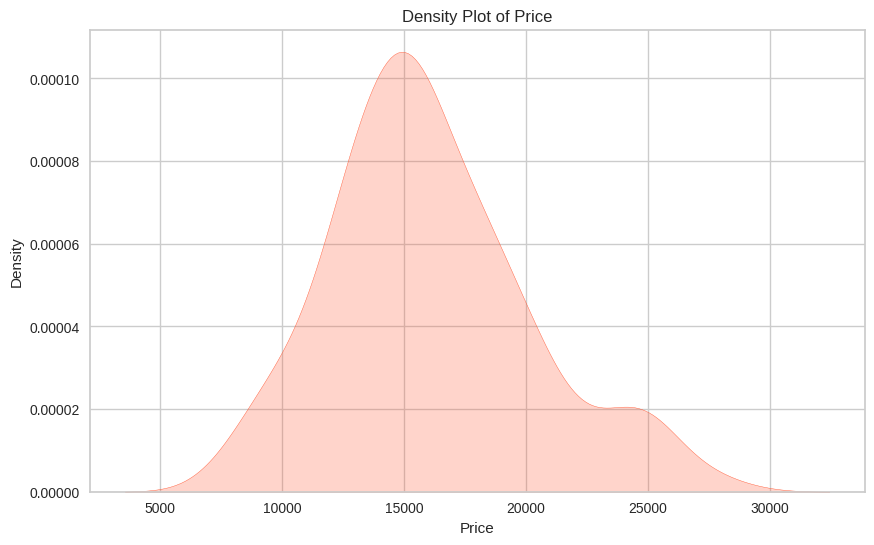

In [ ]:
# Yoğunluk grafiği oluşturma (örneğin "Price" sütununu kullanarak)
plt.figure(figsize=(10, 6))
sns.kdeplot(df_clean_iqr['Price'], color="#FF5733", fill=True)
plt.title('Density Plot of Price')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

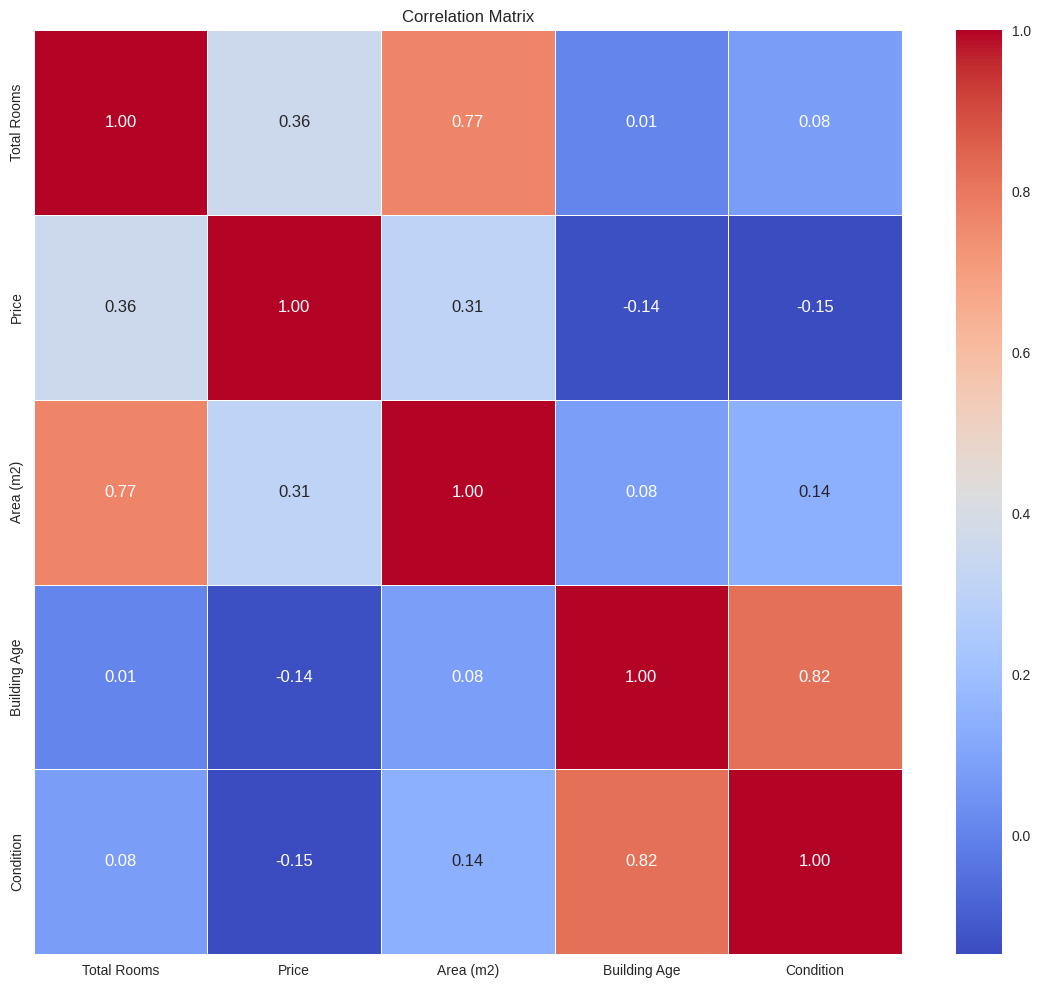

In [ ]:
# Sadece sayısal sütunları seçme
numeric_cols = df_clean_iqr.select_dtypes(include=[np.number])

# Korelasyon matrisi ve ısı haritası oluşturma
plt.figure(figsize=(14, 12))
corr_matrix = numeric_cols.corr()  # Sadece sayısal sütunlar ile korelasyon matrisi hesaplama
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

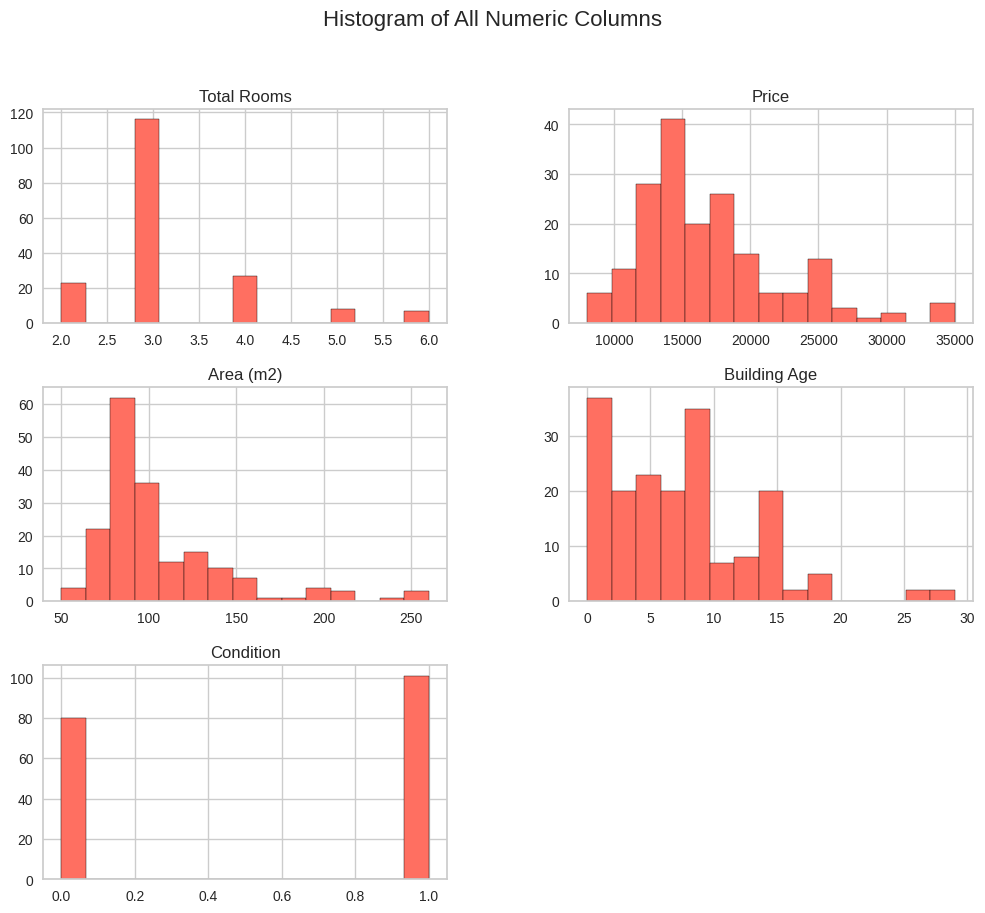

In [ ]:
# Her sütun için histogram
data.hist(figsize=(12, 10), bins=15, color='#FF6F61', edgecolor='black')
plt.suptitle("Histogram of All Numeric Columns", fontsize=16)
plt.show()

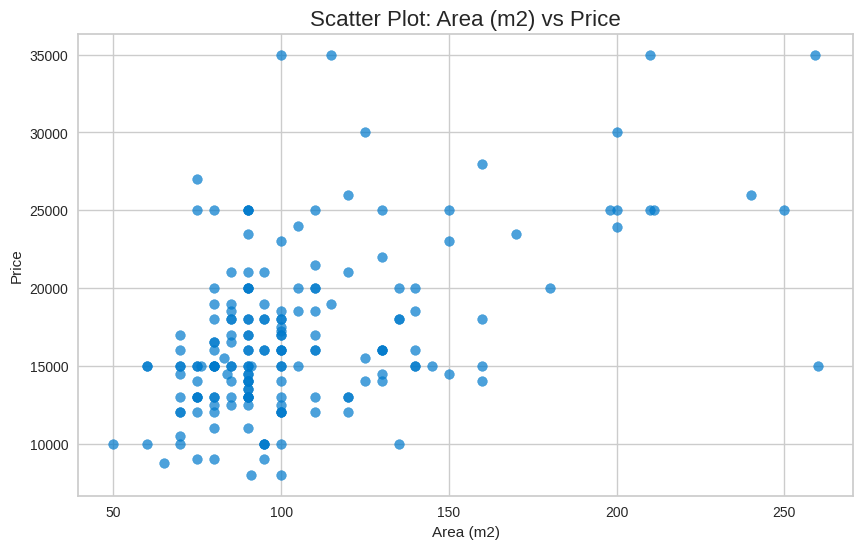

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data['Area (m2)'], data['Price'], color="#007acc", alpha=0.7)
plt.title("Scatter Plot: Area (m2) vs Price", fontsize=16)
plt.xlabel("Area (m2)")
plt.ylabel("Price")
plt.grid(True)
plt.show()

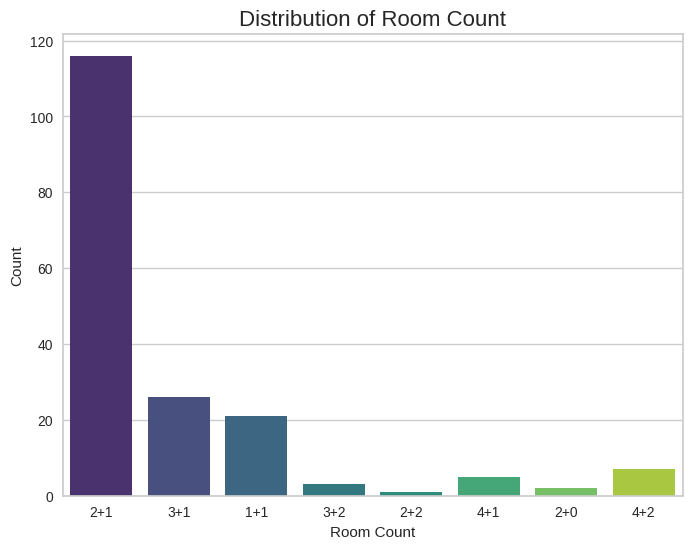

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Room Count', data=data, palette='viridis')
plt.title("Distribution of Room Count", fontsize=16)
plt.xlabel("Room Count")
plt.ylabel("Count")
plt.show()

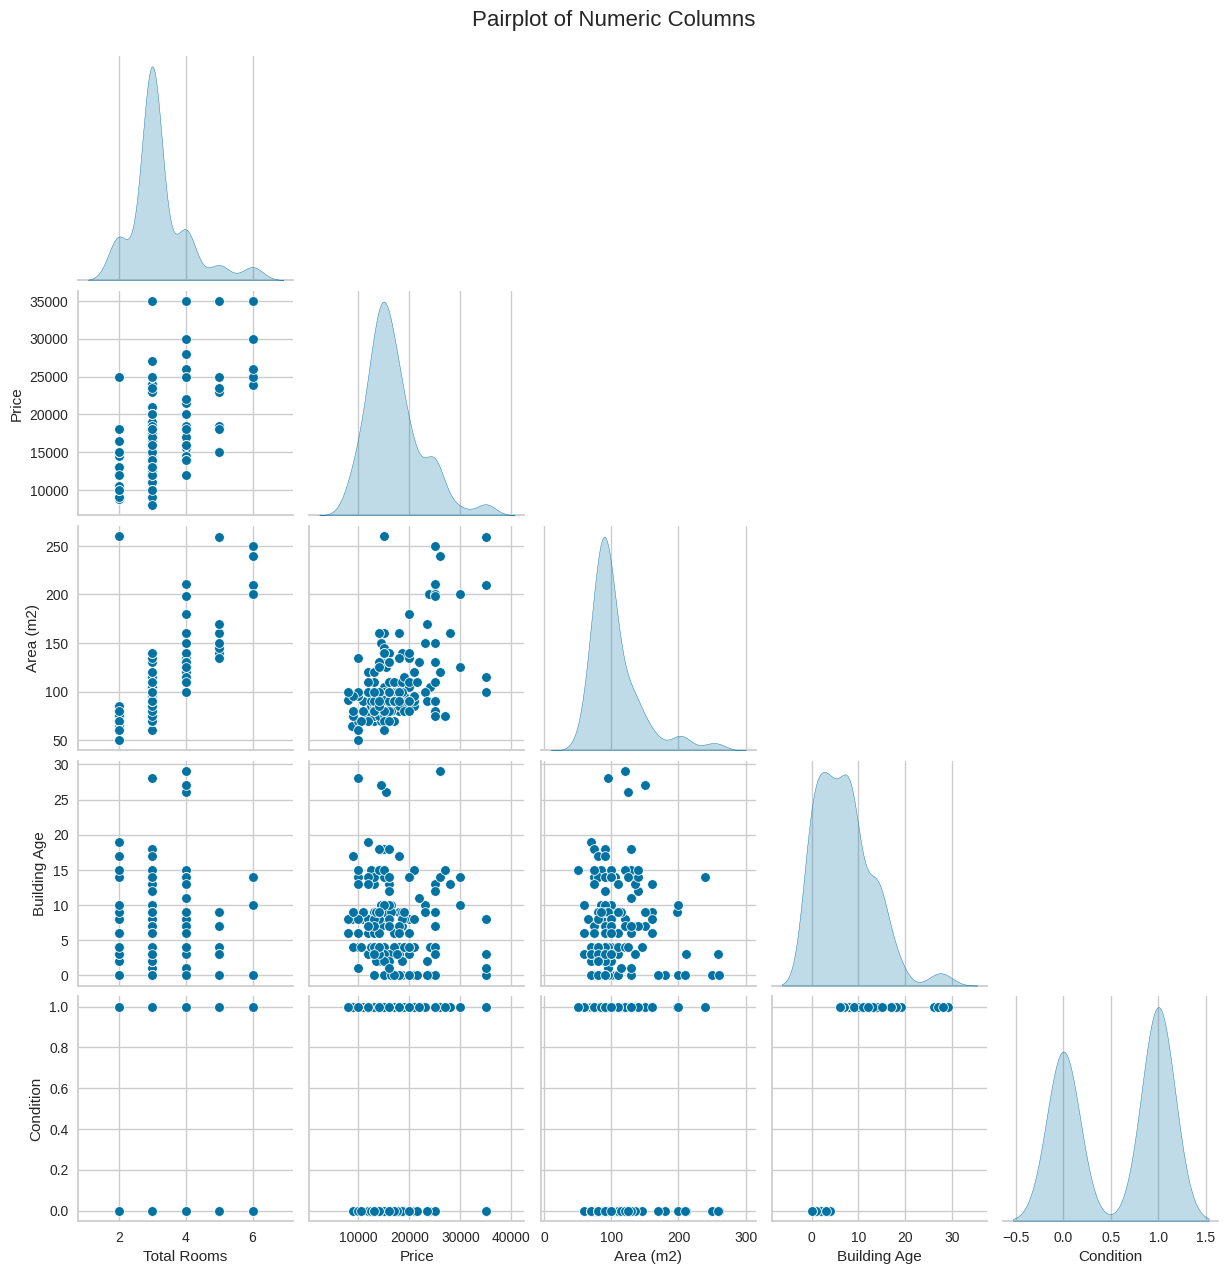

In [ ]:
sns.pairplot(data, diag_kind="kde", corner=True, palette="coolwarm")
plt.suptitle("Pairplot of Numeric Columns", y=1.02, fontsize=16)
plt.show()

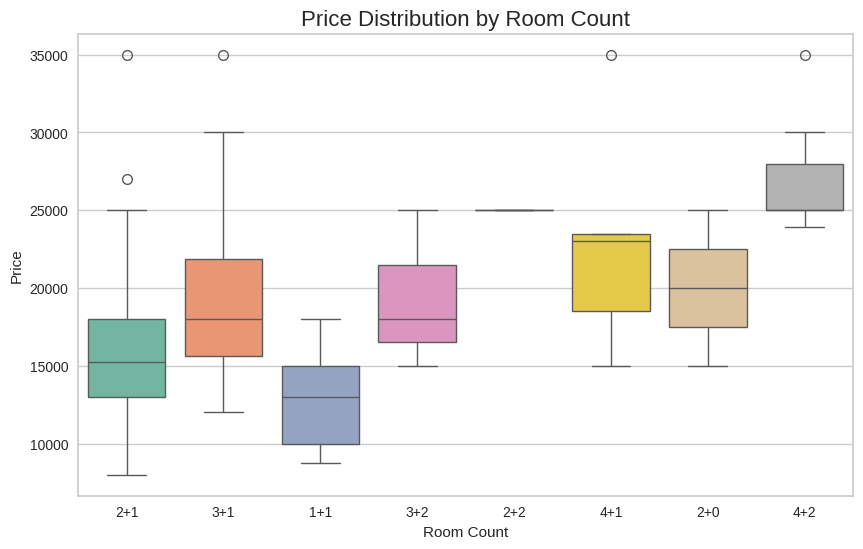

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Room Count', y='Price', data=data, palette="Set2")
plt.title("Price Distribution by Room Count", fontsize=16)
plt.xlabel("Room Count")
plt.ylabel("Price")
plt.show()

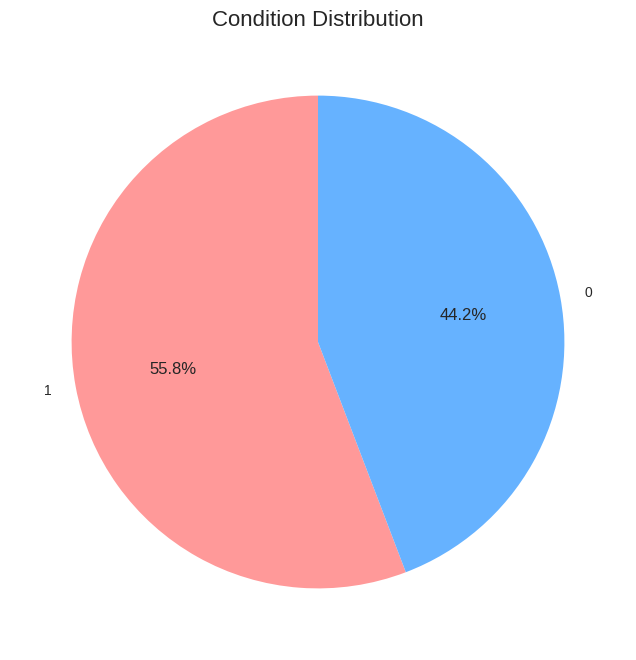

In [ ]:
data['Condition'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', figsize=(8, 8), colors=['#FF9999', '#66B2FF'], startangle=90
)
plt.title("Condition Distribution", fontsize=16)
plt.ylabel("")  # Y eksenini kaldırıyoruz
plt.show()

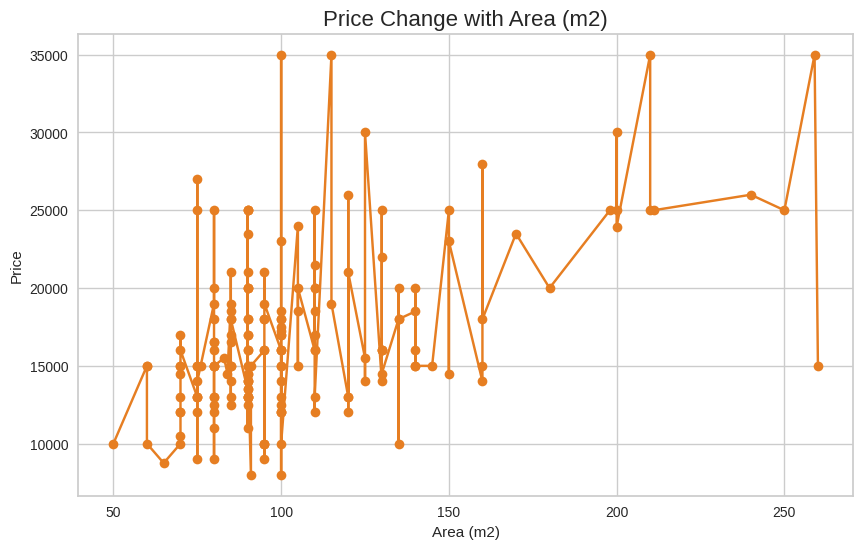

In [ ]:
data_sorted = data.sort_values(by='Area (m2)')
plt.figure(figsize=(10, 6))
plt.plot(data_sorted['Area (m2)'], data_sorted['Price'], marker='o', linestyle='-', color="#E67E22")
plt.title("Price Change with Area (m2)", fontsize=16)
plt.xlabel("Area (m2)")
plt.ylabel("Price")
plt.grid(True)
plt.show()

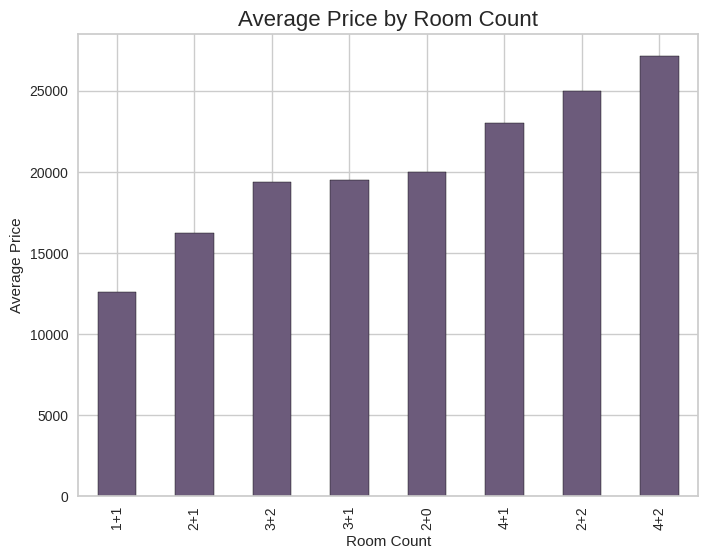

In [ ]:
avg_price_per_room = data.groupby('Room Count')['Price'].mean().sort_values()
avg_price_per_room.plot(kind='bar', color="#6C5B7B", figsize=(8, 6), edgecolor="black")
plt.title("Average Price by Room Count", fontsize=16)
plt.xlabel("Room Count")
plt.ylabel("Average Price")
plt.show()

In [ ]:
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.33, random_state=0)

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

In [ ]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Hiperparametre aralıkları
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Düzenleme terimi
    'C': [0.01, 0.1, 1, 10, 100],  # Regularizasyon parametresi
    'solver': ['liblinear', 'saga'],  # Çözücü algoritmaları
    'max_iter': [100, 200, 500]  # Maksimum iterasyon sayısı
}

# LogisticRegression modelini GridSearchCV ile optimize et
grid_search = GridSearchCV(LogisticRegression(random_state=0), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# En iyi hiperparametre kombinasyonu
print("En iyi parametreler:", grid_search.best_params_)

# Optimum model ile tahmin yap
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Performans değerlendirme
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

En iyi parametreler: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Confusion Matrix:
 [[ 3 21]
 [ 4 38]]
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.12      0.19        24
           1       0.64      0.90      0.75        42

    accuracy                           0.62        66
   macro avg       0.54      0.51      0.47        66
weighted avg       0.57      0.62      0.55        66



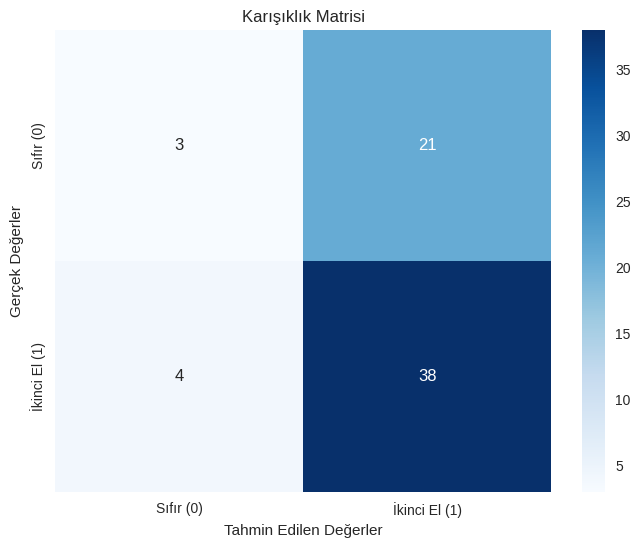

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Karışıklık matrisini hesaplama
cm = confusion_matrix(y_test, y_pred)

# Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sıfır (0)', 'İkinci El (1)'],
            yticklabels=['Sıfır (0)', 'İkinci El (1)'])
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.title('Karışıklık Matrisi')

# Display the plot
plt.show()

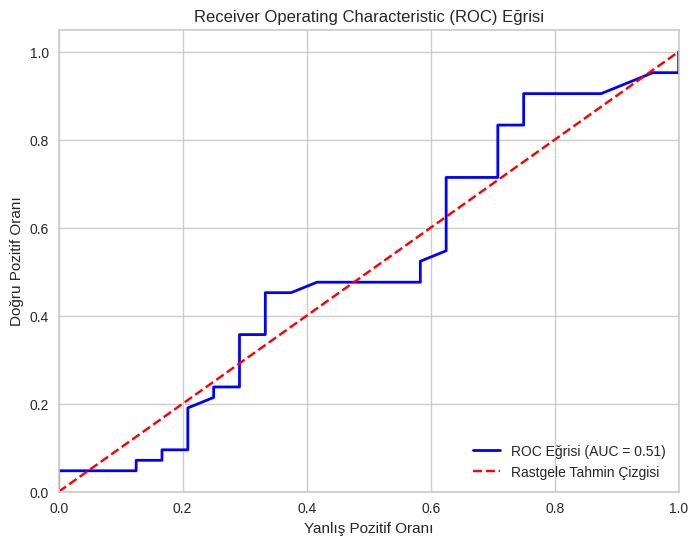

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC eğrisi için tahmin olasılıklarını hesaplama
y_prob = best_model.predict_proba(X_test)[:, 1]  # Pozitif sınıfın olasılıkları
fpr, tpr, thresholds = roc_curve(y_test, y_prob)  # ROC eğrisi için FPR ve TPR değerleri
roc_auc = auc(fpr, tpr)  # AUC değerini hesaplama

# Görselleştirme
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Eğrisi (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Rastgele Tahmin Çizgisi')  # Rastgele çizgi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı')
plt.ylabel('Doğru Pozitif Oranı')
plt.title('Receiver Operating Characteristic (ROC) Eğrisi')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#SVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Hiperparametre aralıkları
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularizasyon parametresi
    'gamma': [1, 0.1, 0.01, 0.001],  # RBF kernel için gamma
    'kernel': ['rbf']  # Kullanılacak kernel tipi
}

# GridSearchCV ile hiperparametre optimizasyonu
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# En iyi hiperparametre kombinasyonu
print("En iyi parametreler:", grid_search.best_params_)

# Optimum model ile tahmin yap
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Performans değerlendirme
cm = confusion_matrix(y_test, y_pred)
print("SVC - Confusion Matrix:\n", cm)

report = classification_report(y_test, y_pred)
print("SVC - Classification Report:\n", report)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

En iyi parametreler: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
SVC - Confusion Matrix:
 [[ 0 24]
 [ 0 42]]
SVC - Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.64      1.00      0.78        42

    accuracy                           0.64        66
   macro avg       0.32      0.50      0.39        66
weighted avg       0.40      0.64      0.49        66

Accuracy Score: 0.6363636363636364


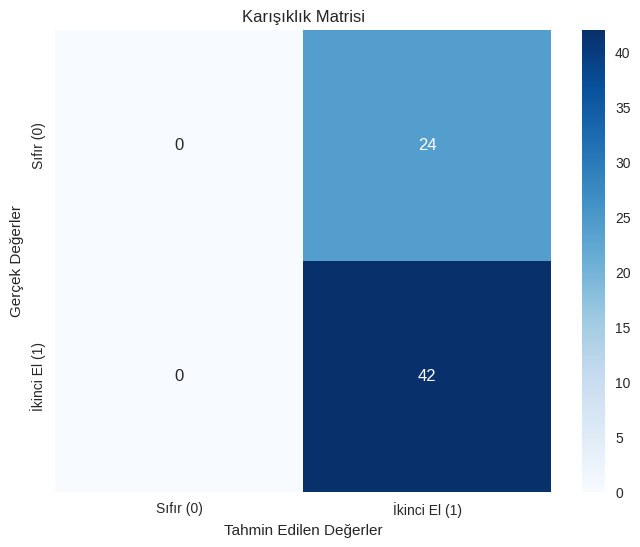

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Karışıklık matrisini hesaplama
cm = confusion_matrix(y_test, y_pred)

# Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sıfır (0)', 'İkinci El (1)'],
            yticklabels=['Sıfır (0)', 'İkinci El (1)'])
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.title('Karışıklık Matrisi')

# Display the plot
plt.show()

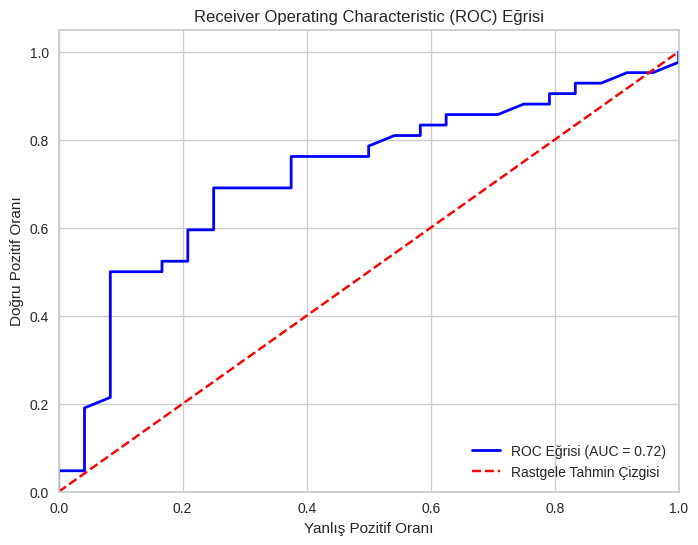

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC eğrisi için karar fonksiyonunu kullanma
y_score = best_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Görselleştirme
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Eğrisi (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Rastgele Tahmin Çizgisi')  # Rastgele çizgi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı')
plt.ylabel('Doğru Pozitif Oranı')
plt.title('Receiver Operating Characteristic (ROC) Eğrisi')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#GaussianNaiveBayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
# Hiperparametre aralıkları
param_grid = {
    'var_smoothing': [1e-09, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Varyans düzeltmesi
}

# GridSearchCV ile hiperparametre optimizasyonu
grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# En iyi hiperparametre kombinasyonu
print("En iyi parametreler:", grid_search.best_params_)

# Optimum model ile tahmin yap
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Performans değerlendirme
cm = confusion_matrix(y_test, y_pred)
print("GNB - Confusion Matrix:\n", cm)

report = classification_report(y_test, y_pred)
print("GNB - Classification Report:\n", report)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

En iyi parametreler: {'var_smoothing': 1e-09}
GNB - Confusion Matrix:
 [[20  4]
 [39  3]]
GNB - Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.83      0.48        24
           1       0.43      0.07      0.12        42

    accuracy                           0.35        66
   macro avg       0.38      0.45      0.30        66
weighted avg       0.40      0.35      0.25        66

Accuracy Score: 0.3484848484848485


In [ ]:
#DecisionTree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Entropi, Gini, Log Loss kriterleri
    'max_depth': [None, 5, 10, 15, 20],            # Maksimum derinlik değerleri
    'min_samples_split': [2, 5, 10],               # Düğüm bölme için minimum örnek sayısı
    'min_samples_leaf': [1, 2, 5, 10],             # Yaprak düğümdeki minimum örnek sayısı
    'max_features': [None, 'sqrt', 'log2']         # Maksimum özellik sayısı
}

# Model oluşturma
dtc = DecisionTreeClassifier()

# GridSearchCV ile optimizasyon
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# En iyi parametreler
print("En iyi parametreler:", grid_search.best_params_)

# En iyi model ile test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Performans değerlendirme
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

En iyi parametreler: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2}
Confusion Matrix:
[[17  7]
 [16 26]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.71      0.60        24
           1       0.79      0.62      0.69        42

    accuracy                           0.65        66
   macro avg       0.65      0.66      0.64        66
weighted avg       0.69      0.65      0.66        66

Accuracy Score: 0.6515151515151515


In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],  # Komşu sayısı
    'weights': ['uniform', 'distance'],  # Ağırlık türü
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Mesafe ölçümü
}

# Model oluşturma
knn = KNeighborsClassifier()

# GridSearchCV ile optimizasyon
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# En iyi parametreler
print("En iyi parametreler:", grid_search.best_params_)

# En iyi model ile test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Performans değerlendirme
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

En iyi parametreler: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Confusion Matrix:
[[17  7]
 [20 22]]
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.71      0.56        24
           1       0.76      0.52      0.62        42

    accuracy                           0.59        66
   macro avg       0.61      0.62      0.59        66
weighted avg       0.65      0.59      0.60        66

Accuracy Score: 0.5909090909090909


In [ ]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Hiperparametre aralıkları
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Ağaç sayısı
    'criterion': ['gini', 'entropy', 'log_loss'],  # Bölünme ölçütü
    'max_depth': [None, 10, 20, 30],  # Maksimum derinlik
    'min_samples_split': [2, 5, 10],  # Bölünme için minimum örnek sayısı
    'min_samples_leaf': [1, 2, 4],  # Bir yaprakta bulunması gereken minimum örnek sayısı
    'max_features': ['sqrt', 'log2', None]  # Özellik alt kümelerinin seçimi
}

# GridSearchCV ile hiperparametre optimizasyonu
grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# En iyi hiperparametre kombinasyonu
print("En iyi parametreler:", grid_search.best_params_)

# Optimum model ile tahmin
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Performans değerlendirme
cm = confusion_matrix(y_test, y_pred)
print("RFC - Confusion Matrix:\n", cm)

report = classification_report(y_test, y_pred)
print("RFC - Classification Report:\n", report)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

En iyi parametreler: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
RFC - Confusion Matrix:
 [[15  9]
 [13 29]]
RFC - Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.62      0.58        24
           1       0.76      0.69      0.72        42

    accuracy                           0.67        66
   macro avg       0.65      0.66      0.65        66
weighted avg       0.68      0.67      0.67        66

Accuracy Score: 0.6666666666666666


In [ ]:
#XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Hiperparametre kombinasyonları
param_combinations = [
    {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1},
    {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 1.5},
    {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 2},
    # Diğer kombinasyonlar eklenebilir
]

# Sonuçları tutmak için boş liste
results = []

# Döngü ile kombinasyonları deneme
for params in param_combinations:
    model = XGBClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        random_state=0
    )

    # Modeli eğit
    model.fit(X_train, y_train)

    # Tahmin yap
    y_pred = model.predict(X_test)

    # Performans değerlendirme
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Sonuçları sakla
    results.append({
        'params': params,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report
    })

    print(f"Model parametreleri: {params}")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)
    print("-" * 50)

# En iyi sonucu seçmek için en yüksek doğruluğa sahip olan modeli seçebilirsiniz
best_result = max(results, key=lambda x: x['accuracy'])
print("En iyi model parametreleri:", best_result['params'])
print(f"En iyi Accuracy: {best_result['accuracy']}")


Model parametreleri: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
Accuracy: 0.6818181818181818
Confusion Matrix:
 [[17  7]
 [14 28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.71      0.62        24
           1       0.80      0.67      0.73        42

    accuracy                           0.68        66
   macro avg       0.67      0.69      0.67        66
weighted avg       0.71      0.68      0.69        66

--------------------------------------------------
Model parametreleri: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 1.5}
Accuracy: 0.6212121212121212
Confusion Matrix:
 [[16  8]
 [17 25]]
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.67      0

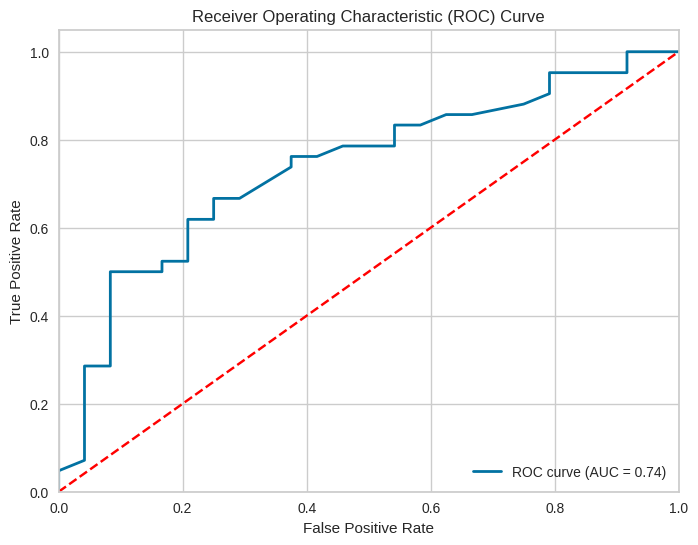

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# En iyi modelin parametreleri
best_params = best_result['params']

# En iyi modeli tekrar eğit
best_model = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=0
)

best_model.fit(X_train, y_train)

# Modelden tahmin olasılıkları al
y_prob = best_model.predict_proba(X_test)[:, 1]  # Pozitif sınıf için

# ROC eğrisini hesapla
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çiz
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Yalnızca rastgele tahmin çizgisi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Temel model (DecisionTreeClassifier)
base_estimator = DecisionTreeClassifier(criterion='entropy')

# Parametreler
param_grid = {
    'estimator__max_depth': [1, 2, 3, 4],  # Temel öğrenicinin derinliği
    'n_estimators': [50, 100, 150],  # Öğrenici sayısı
    'learning_rate': [0.01, 0.1, 1.0],  # Öğrenme oranı
    'algorithm': ['SAMME', 'SAMME.R']  # Algoritma türü
}

# AdaBoost model tanımlama
adaboost = AdaBoostClassifier(estimator=base_estimator, random_state=0)

# GridSearchCV ile optimizasyon
grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Eğitim verisi üzerinde grid search
grid_search.fit(X_train, y_train)

# En iyi parametreler
print("En iyi parametreler:", grid_search.best_params_)

# En iyi model ile tahmin yapma
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")



En iyi parametreler: {'algorithm': 'SAMME', 'estimator__max_depth': 4, 'learning_rate': 1.0, 'n_estimators': 100}
Confusion Matrix:
[[16  8]
 [23 19]]

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.67      0.51        24
           1       0.70      0.45      0.55        42

    accuracy                           0.53        66
   macro avg       0.56      0.56      0.53        66
weighted avg       0.60      0.53      0.54        66

Accuracy Score: 0.5303030303030303


In [ ]:
#MLP
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# MLP için parametreler
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],  # Gizli katman boyutları
    'activation': ['relu', 'tanh', 'logistic'],  # Aktivasyon fonksiyonları
    'solver': ['adam', 'sgd', 'lbfgs'],  # Optimizasyon algoritmaları
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Öğrenme oranı ayarlama
    'max_iter': [200, 300, 500]  # Maksimum iterasyon sayısı
}

# MLP modeli
mlp = MLPClassifier(random_state=0)

# GridSearchCV ile optimizasyon
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# GridSearchCV ile eğitim verisi üzerinde optimizasyon
grid_search.fit(X_train, y_train)

# En iyi parametreleri yazdırma
print("En iyi parametreler:", grid_search.best_params_)

# En iyi model ile tahmin yapma
best_mlp_model = grid_search.best_estimator_
y_pred = best_mlp_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")


En iyi parametreler: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 200, 'solver': 'sgd'}
Confusion Matrix:
[[12 12]
 [12 30]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        24
           1       0.71      0.71      0.71        42

    accuracy                           0.64        66
   macro avg       0.61      0.61      0.61        66
weighted avg       0.64      0.64      0.64        66

Accuracy Score: 0.6363636363636364
